## セクション８　決定木
- 回帰にも分類にも使用できるアルゴリズム
- 人間の意思決定のロジックに近いので、解釈しやすい
- 単体では精度が低い
- 複巣の決定機を組み合わせることで非常に高い精度のモデルを構築可能
- 分岐の部分をノード、分岐を枝、末端を葉という

In [9]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import plot_tree,export_text
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### 領域の分割の仕方（回帰の場合）
- 分割後の二つの領域の偏差の平方和の合計が最小になるように二分していく
### 領域の分割の仕方（分類の場合）
- 分割後の二つの領域のジニ不純度が最小になるように二分していくG = p(k)(1-p(k))のクラス数を全て合計p(k)はその領域でのクラスkの割合
### 決定木の過学習
- 分割を進めていくとモデルが複雑になり過学習となり汎化性能が下がる
- 精度が下がり解釈性が下がり、学習に時間がかかる　
#### 途中で分割を終えたり、木を剪定して小さくする必要がある
- 決定木の損失関数 Rα（T） = R(T) + α|T| (α：パラメータ、|T|:決定木の数)

In [5]:
# データ準備
df = sns.load_dataset('tips')
df = pd.get_dummies(df, drop_first=True)
y_col = 'tip'
X = df.drop(columns=[y_col])
y = df[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 決定木モデル(回帰)　ccp_alpha:alphaの値を指定することができる、パラメータを指定しないと最後まで分類するので注意
model = tree.DecisionTreeRegressor(max_depth=4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred)

1.1060246260428703

In [3]:
# R^2
model.score(X_test, y_test) # R-squared

0.3590618660303134

### 決定木モデルを可視化する
- 決定木の描画 sklearn.tree.plot_tree
  - (desicion_tree；モデルインスタンス,fontsize:フォントサイズ,feature_name:model.feature_names_in_便利)
- テキストベースの可視化 sklearn.tree.export_text
  - 使い方はplot_treeと同じ
  - print（）で出力することで綺麗に表示される


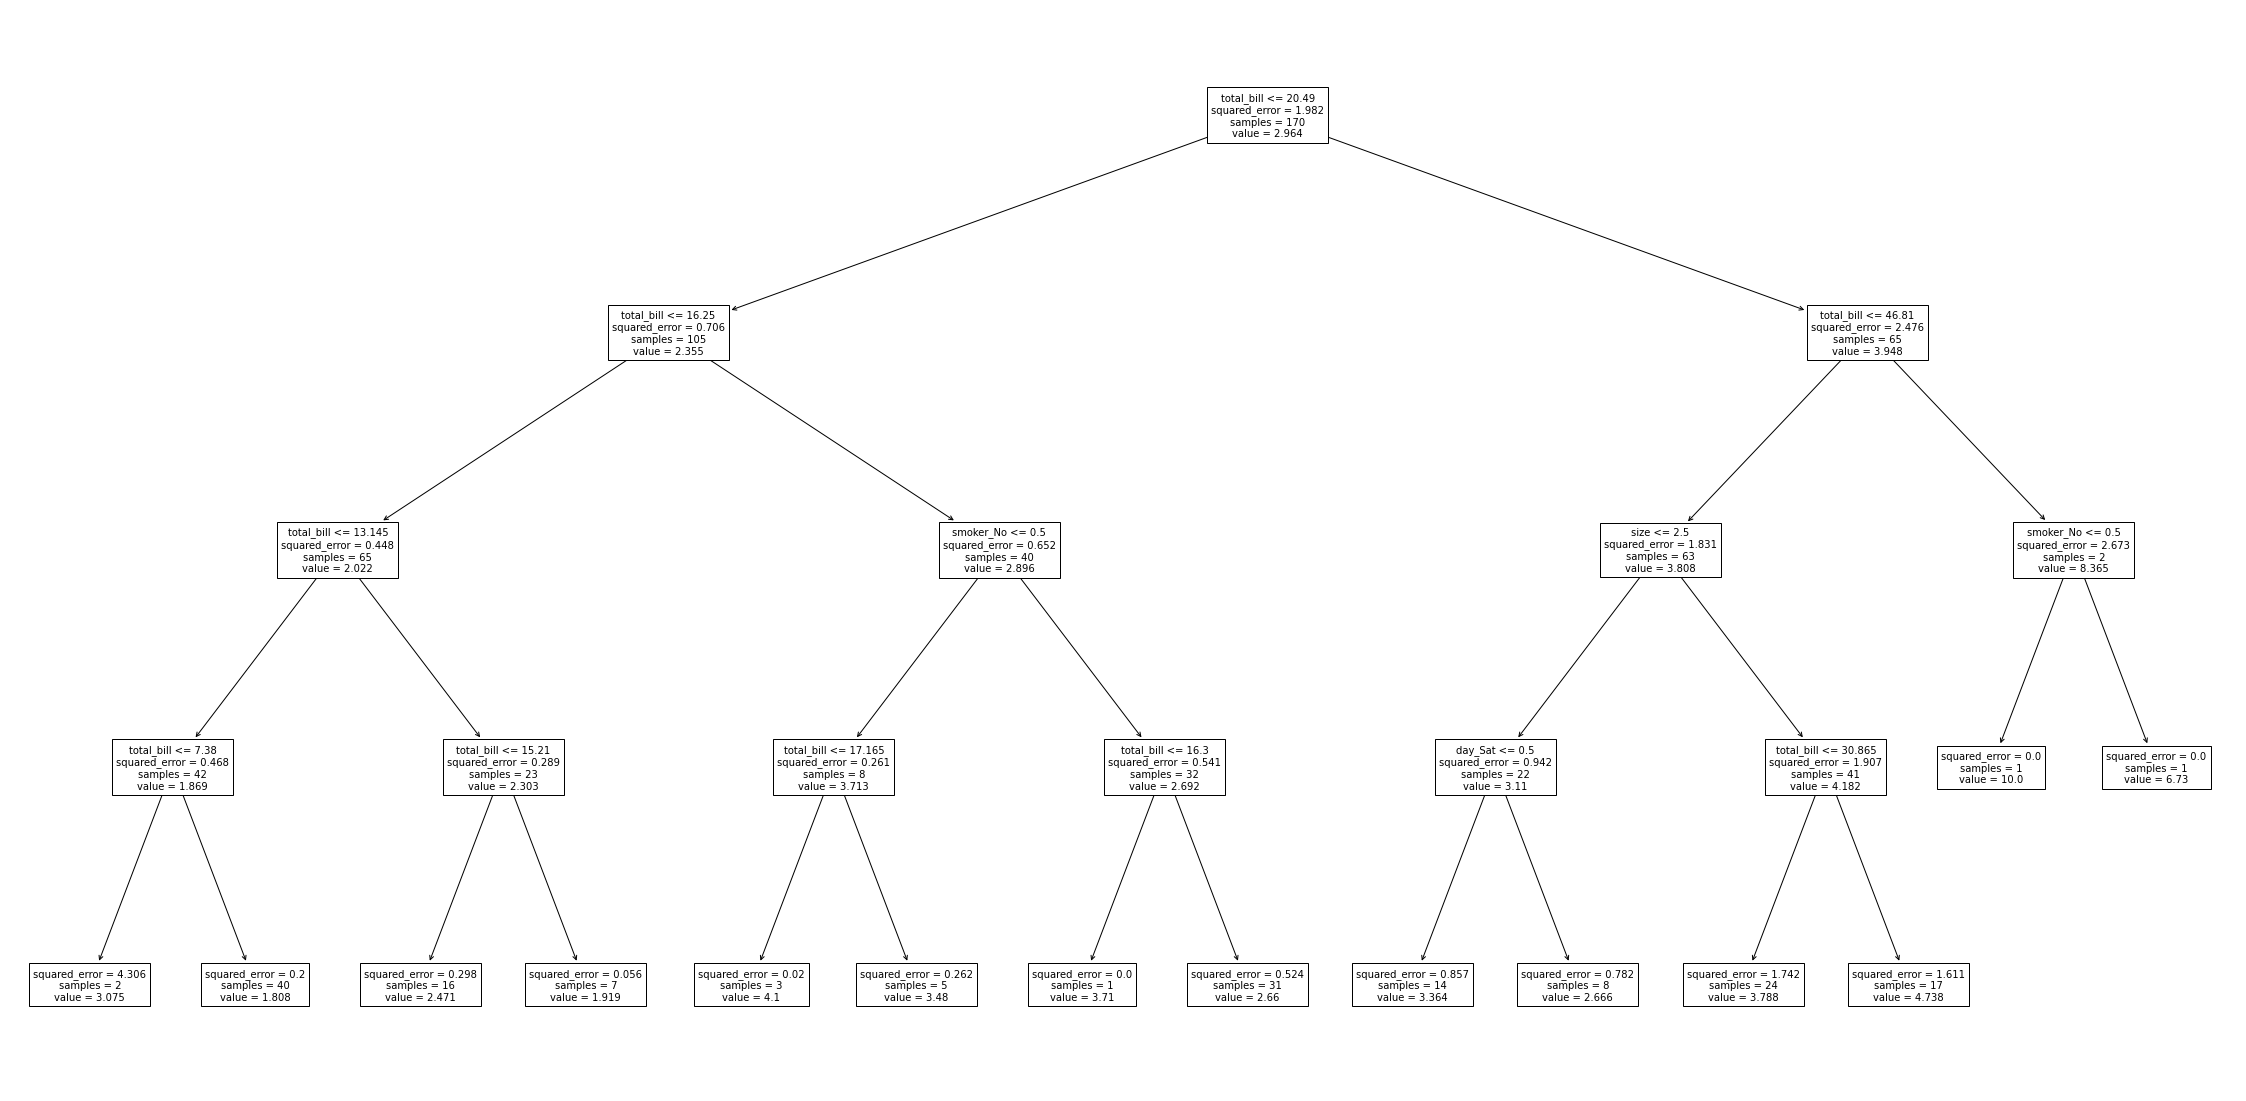

In [10]:
plt.figure(figsize=(40,20))
plot_tree(model,fontsize=10,feature_names=model.feature_names_in_)
plt.show()

In [11]:
# テキストベースの可視化
print(tree.export_text(model, feature_names=list(model.feature_names_in_)))

|--- total_bill <= 20.49
|   |--- total_bill <= 16.25
|   |   |--- total_bill <= 13.14
|   |   |   |--- total_bill <= 7.38
|   |   |   |   |--- value: [3.08]
|   |   |   |--- total_bill >  7.38
|   |   |   |   |--- value: [1.81]
|   |   |--- total_bill >  13.14
|   |   |   |--- total_bill <= 15.21
|   |   |   |   |--- value: [2.47]
|   |   |   |--- total_bill >  15.21
|   |   |   |   |--- value: [1.92]
|   |--- total_bill >  16.25
|   |   |--- smoker_No <= 0.50
|   |   |   |--- total_bill <= 17.16
|   |   |   |   |--- value: [4.10]
|   |   |   |--- total_bill >  17.16
|   |   |   |   |--- value: [3.48]
|   |   |--- smoker_No >  0.50
|   |   |   |--- total_bill <= 16.30
|   |   |   |   |--- value: [3.71]
|   |   |   |--- total_bill >  16.30
|   |   |   |   |--- value: [2.66]
|--- total_bill >  20.49
|   |--- total_bill <= 46.81
|   |   |--- size <= 2.50
|   |   |   |--- day_Sat <= 0.50
|   |   |   |   |--- value: [3.36]
|   |   |   |--- day_Sat >  0.50
|   |   |   |   |--- value: [2.67]

### 特徴量の重要度

In [12]:
# 各特徴量の重要度
model.feature_importances_

array([0.85278323, 0.07825569, 0.        , 0.05715192, 0.        ,
       0.01180916, 0.        , 0.        ])

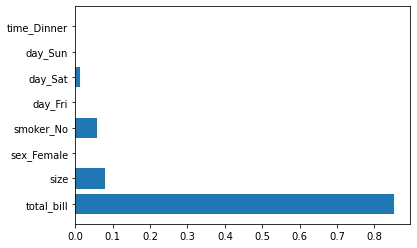

In [13]:
plt.barh(model.feature_names_in_, model.feature_importances_)
plt.show()

### minimal cost complecity pruning
- model.cost_complexity_pruning_path(X_train, y_train)でαと不純度をリストで取得する
- それぞれのαでのモデルの精度を計測し、最良のαを使用する

In [14]:
model = tree.DecisionTreeRegressor(random_state=0)
# 決定木を剪定する閾値となるαと不純度のリスト
path = model.cost_complexity_pruning_path(X_train, y_train)
eff_alphas = path.ccp_alphas

In [17]:
# 各αでのモデルを構築
models = []
for eff_alpha in eff_alphas:
    model = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=eff_alpha)
    model.fit(X_train, y_train)
    models.append(model)

In [18]:
# それぞれのモデルの精度指標を記録(上記のfor文の中で実行した方が効率がいいが，ここでは別ループにて実行する)
from sklearn.metrics import mean_squared_error
train_scores = [mean_squared_error(y_train, model.predict(X_train)) for model in models]
test_scores = [mean_squared_error(y_test, model.predict(X_test)) for model in models]

Text(0, 0.5, 'MSE')

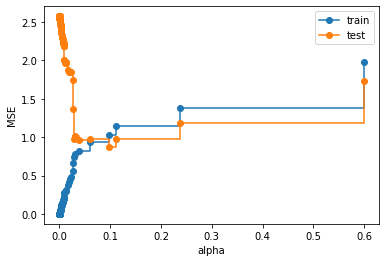

In [19]:
# 各αで剪定したときのモデルの精度の推移を描画
plt.plot(eff_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
plt.plot(eff_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('MSE')